In [1]:
import numpy as np
import Scripts.cifar_resnet as rn
import Scripts.wake_processing as wp
import importlib
import Scripts.autoencoder as ae
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
%matplotlib inline

In [2]:
import Scripts.smoothing as smooth

In [3]:
importlib.reload(rn)
importlib.reload(wp)

<module 'Scripts.wake_processing' from 'E:\\Studies\\Deep Water\\DeepWater\\Scripts\\wake_processing.py'>

## Training Data

In [4]:
real_wakes = np.load("Data\\Wake data\\confirmed_wakes.npy")
generated_wakes = np.load("Data\\Wake data\\generated_wakes.npy")
not_wakes = np.load("Data\\Wake data\\negative_day_samples.npy")
real_wakes = real_wakes[:,:,:-1,:]
not_wakes = not_wakes[:,:,:-1,:]
train_real, test_real = train_test_split(real_wakes, test_size=0.2, random_state=4)
train_gen, test_gen = train_test_split(generated_wakes, test_size=0.08, random_state=4)
train_neg, test_neg = train_test_split(not_wakes, test_size = 0.06, random_state = 4)
test_pos = np.append(test_real, test_gen, axis = 0)
train_pos = np.append(train_real, train_gen, axis = 0)
test_x = np.append(test_pos, test_neg, axis = 0)
train_x = np.append(train_pos, train_neg, axis = 0)
test_pos_y = np.concatenate((np.ones(test_pos.shape[0]).reshape(-1,1), np.zeros(test_pos.shape[0]).reshape(-1,1)), axis = 1)
test_neg_y = np.concatenate((np.zeros(test_neg.shape[0]).reshape(-1,1), np.ones(test_neg.shape[0]).reshape(-1,1)), axis = 1)
train_pos_y = np.concatenate((np.ones(train_pos.shape[0]).reshape(-1,1), np.zeros(train_pos.shape[0]).reshape(-1,1)), axis = 1)
train_neg_y = np.concatenate((np.zeros(train_neg.shape[0]).reshape(-1,1), np.ones(train_neg.shape[0]).reshape(-1,1)), axis = 1)
test_y = np.append(test_pos_y, test_neg_y, axis = 0)
train_y = np.append(train_pos_y, train_neg_y, axis = 0)

In [5]:
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

In [6]:
test_dataset.tensors[0].shape

torch.Size([118, 4, 28, 60])

In [7]:
test_dataset.tensors[1].shape

torch.Size([118, 2])

## Train function

In [8]:
def train_rn(model, train_data, test_data, num_epochs=5, batch_size=5, learning_rate=1e-3):
    model = model.to(device)
    torch.manual_seed(0)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=0, drop_last=True)
    X_val, y_val = test_data.tensors[0].to(device), test_data.tensors[1].to(device)
    train_losses = []
    val_losses = []
    val_accs = []
    train_accs= []
    for epoch in range(num_epochs):
        total_loss = []
        batch_accs = []
        for i, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_pred_label = 1 - torch.argmax(pred, dim = 1).cpu().detach().numpy()
            train_true_label = 1 - torch.argmax(y, dim = 1).cpu().detach().numpy()
            batch_acc = accuracy_score(train_true_label, train_pred_label)
            batch_accs.append(batch_acc)
            total_loss.append(loss.item())
            
        val_pred = model(X_val)
        val_pred_label = 1 - torch.argmax(val_pred, dim = 1).cpu().detach().numpy()
        val_true_label = 1 - torch.argmax(y_val, dim = 1).cpu().detach().numpy()
        val_loss = criterion(val_pred, y_val).item()
        train_loss = sum(total_loss)/len(total_loss)
        train_acc = sum(batch_accs)/len(batch_accs)
        val_acc = accuracy_score(val_true_label, val_pred_label)
        print('Epoch:{}, Loss:{:.4f}, Val Loss:{:.4f}, Train Acc:{:4f}, Val Acc:{:.4f}'.format(epoch+1, train_loss,
                                                                                               val_loss, train_acc, val_acc))
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        train_accs.append(train_acc)
    return train_losses, val_losses, train_accs, val_accs

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training with limited epochs

In [10]:
resnet = None
resnet = rn.ResNet18()
train_losses, val_losses, train_accs, val_accs = train_rn(resnet, train_dataset, test_dataset, num_epochs = 15, learning_rate=1e-4)

Epoch:1, Loss:0.2663, Val Loss:0.2439, Train Acc:0.894928, Val Acc:0.9153
Epoch:2, Loss:0.1547, Val Loss:0.3300, Train Acc:0.949275, Val Acc:0.8475
Epoch:3, Loss:0.1155, Val Loss:0.2484, Train Acc:0.959420, Val Acc:0.9492
Epoch:4, Loss:0.0808, Val Loss:0.2539, Train Acc:0.969565, Val Acc:0.9068
Epoch:5, Loss:0.0390, Val Loss:0.3472, Train Acc:0.986957, Val Acc:0.9153
Epoch:6, Loss:0.0365, Val Loss:0.2827, Train Acc:0.988406, Val Acc:0.9153
Epoch:7, Loss:0.0118, Val Loss:0.3101, Train Acc:0.997101, Val Acc:0.9153
Epoch:8, Loss:0.0450, Val Loss:0.3572, Train Acc:0.986232, Val Acc:0.8983
Epoch:9, Loss:0.0116, Val Loss:0.3131, Train Acc:0.996377, Val Acc:0.9237
Epoch:10, Loss:0.0083, Val Loss:0.6974, Train Acc:0.996377, Val Acc:0.8475
Epoch:11, Loss:0.0091, Val Loss:0.6436, Train Acc:0.997101, Val Acc:0.8644
Epoch:12, Loss:0.0230, Val Loss:0.3845, Train Acc:0.992029, Val Acc:0.9322
Epoch:13, Loss:0.0326, Val Loss:0.3295, Train Acc:0.990580, Val Acc:0.9153
Epoch:14, Loss:0.0064, Val Loss:0.

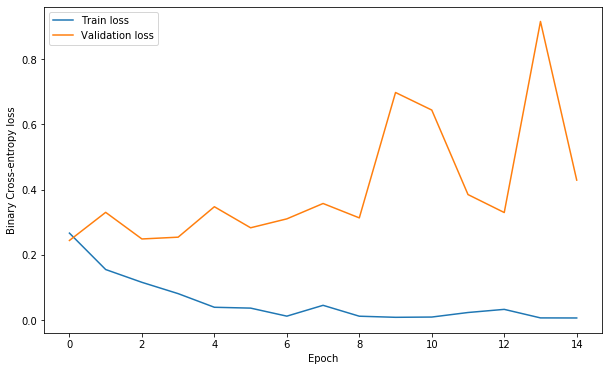

In [13]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label = 'Train loss')
plt.plot(val_losses, label = 'Validation loss')
plt.legend(loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-entropy loss')
plt.show()

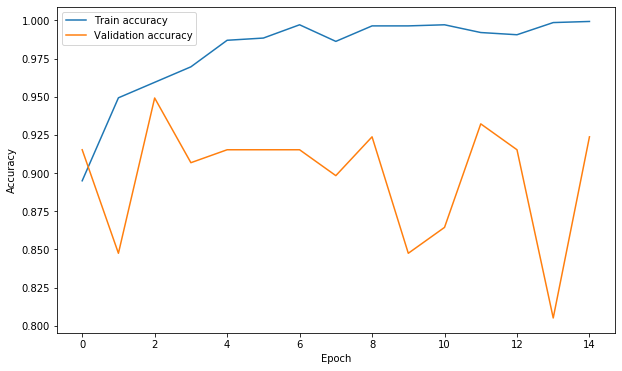

In [14]:
plt.figure(figsize=(10,6))
plt.plot(train_accs, label = 'Train accuracy')
plt.plot(val_accs, label = 'Validation accuracy')
plt.legend(loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Passing Full Training Dataset

In [15]:
smoother = smooth.Smooth(base_classifier = resnet, num_classes = 2, sigma = 0.005)

In [110]:
prediction_smooth = []
for i in tqdm(range(real_wakes.shape[0])):
    next_frame = torch.from_numpy(real_wakes[i]).float().unsqueeze(0).to(device)
    label = smoother.predict(next_frame, n = 500, alpha = 0.01, batch_size = 10)
    prediction_smooth.append(label)
predictions_smooth = np.array(prediction_smooth)

100%|████████████████████████████████████████████████████████████████████████████████| 142/142 [01:36<00:00,  1.35it/s]


In [111]:
# Sigma = 0.005, n = 500
np.unique(prediction_smooth,  return_counts = True)

(array([0, 1], dtype=int64), array([135,   7], dtype=int64))

In [108]:
# Sigma = 0.01, n = 500
np.unique(prediction_smooth,  return_counts = True)

(array([-1,  0,  1], dtype=int64), array([  1, 134,   7], dtype=int64))

In [104]:
# Sigma = 0.05, n = 500
np.unique(prediction_smooth,  return_counts = True)

(array([-1,  0,  1], dtype=int64), array([ 5, 95, 42], dtype=int64))

In [95]:
# Sigma = 0.1, n = 50000
np.unique(prediction_smooth,  return_counts = True)

(array([0, 1], dtype=int64), array([69, 73], dtype=int64))

In [93]:
# Sigma = 0.1, n = 5000
np.unique(prediction_smooth,  return_counts = True)

(array([-1,  0,  1], dtype=int64), array([ 2, 67, 73], dtype=int64))

In [89]:
# Sigma = 0.1, n = 400
np.unique(prediction_smooth,  return_counts = True)

(array([-1,  0,  1], dtype=int64), array([ 8, 65, 69], dtype=int64))

In [85]:
# Sigma = 0.01
np.unique(prediction_smooth,  return_counts = True)

(array([-1,  0,  1], dtype=int64), array([  1, 134,   7], dtype=int64))

In [16]:
predictions_clean = []
for i in real_wakes:
    next_frame = torch.from_numpy(i).float().unsqueeze(0).to(device)
    label = int(torch.argmax(resnet(next_frame), dim = 1).cpu().detach())
    predictions_clean.append(label)
predictions_clean = np.array(predictions_clean)

In [17]:
# Clean
np.unique(predictions_clean,  return_counts = True)

(array([0, 1]), array([132,  10], dtype=int64))

## Smoothing experiment, full data for day

In [18]:
data_series = wp.get_files()
cutoff = np.where(data_series[0,-2]<wp.date_to_stamp([9, 22, 0, 0]))[0][-1]
train_series = data_series[:,:,:cutoff]
test_series = data_series[:,:,cutoff:]

In [20]:
12 //5 

2

In [22]:
prediction_day_smooth = []
for i in tqdm(range((train_series.shape[2] - 60)//5)):
    if train_series[0, -1, 5*i] == 1:
        time = train_series[0, -2, 5*i]
        next_frame = torch.from_numpy(train_series[:,:-2,5*i:5*i+60]).float().unsqueeze(0).to(device)
        label = smoother.predict(next_frame, n = 500, alpha = 0.01, batch_size = 10)
        prediction_day_smooth.append(np.array([time, label]))
predictions_day_smooth = np.array(prediction_day_smooth)

100%|██████████████████████████████████████████████████████████████████████████| 13824/13824 [1:20:35<00:00,  2.86it/s]


NameError: name 'prediction_smooth' is not defined

In [26]:
predictions_day_smooth

(7697,)

In [27]:
np.unique(predictions_day_smooth, return_counts = True)

(array([-1,  0,  1], dtype=int64), array([  50, 1537, 6110], dtype=int64))

In [155]:
predictions = []
for i in tqdm(range((train_series.shape[2] - 60))):
    if train_series[0, -1, i] == 1:
        time = train_series[0, -2, i]
        next_frame = torch.from_numpy(train_series[:,:-2,i:i+60]).float().unsqueeze(0).to(device)
        label = int(torch.argmax(resnet(next_frame), dim = 1).cpu().detach())
        predictions.append(np.array([time, label]))
predictions = np.array(predictions)

100%|███████████████████████████████████████████████████████████████████████████| 69122/69122 [09:18<00:00, 123.79it/s]


In [191]:
predictions_day_night = []
for i in tqdm(range((train_series.shape[2] - 60))):
    time = train_series[0, -2, i]
    next_frame = torch.from_numpy(train_series[:,:-2,i:i+60]).float().unsqueeze(0).to(device)
    label = int(torch.argmax(resnet(next_frame), dim = 1).cpu().detach())
    predictions_day_night.append(np.array([time, label]))     
predictions_day_night = np.array(predictions_day_night)

100%|████████████████████████████████████████████████████████████████████████████| 69122/69122 [28:49<00:00, 39.96it/s]


In [35]:
predictions_day_smooth.shape

(7697,)

In [29]:
predicted_day_smooth = predictions_day_smooth[np.where(predictions_day_smooth == 0)]

In [201]:
unknown_wakes_day = predicted_ws_day
for ws in new_ws:
    unknown_wakes_day = unknown_wakes_day[np.where((ws-1800 >= unknown_wakes_day) | (unknown_wakes_day  >= ws+1800))]

In [203]:
unknown_wakes_day.shape

(2638,)

In [206]:
predicted_wakes = wp.frames_by_timestamps(train_series[:,:-1,:], unknown_wakes_day)

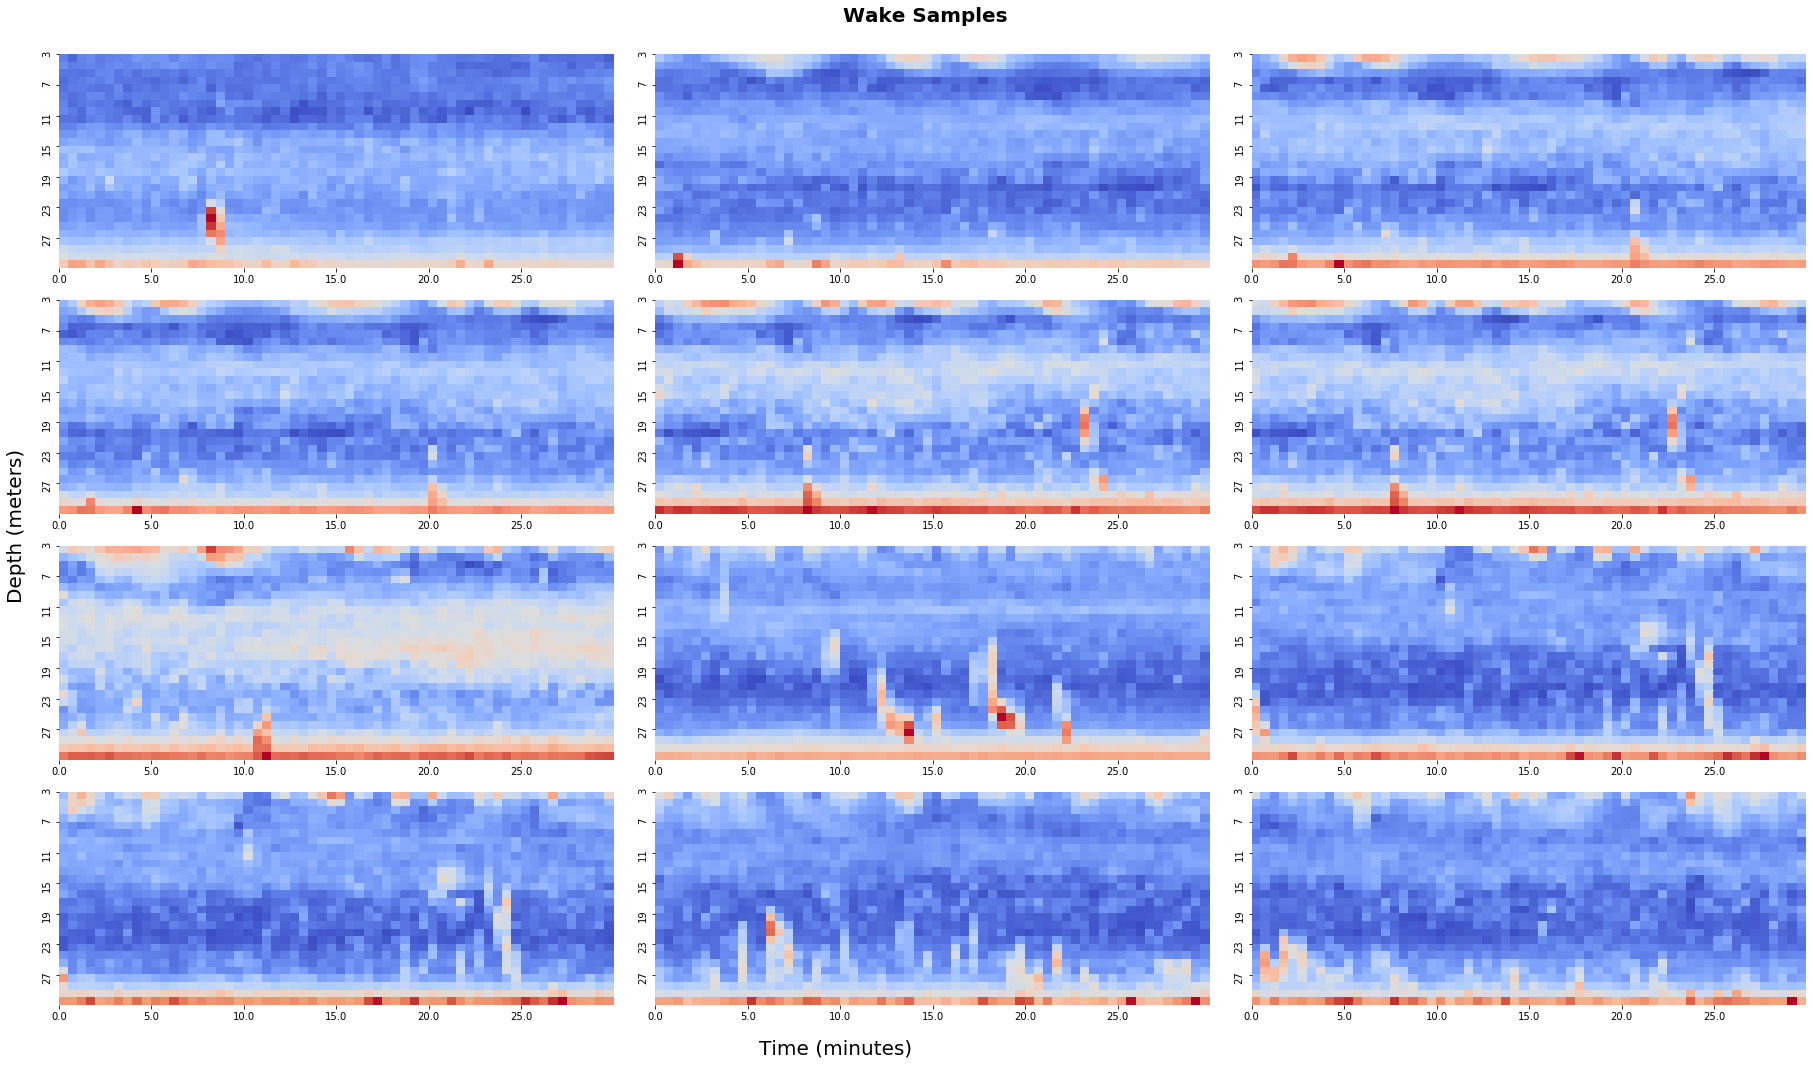

In [207]:
wp.make_12_heatmaps(predicted_wakes[:12, 3, :-1,:])

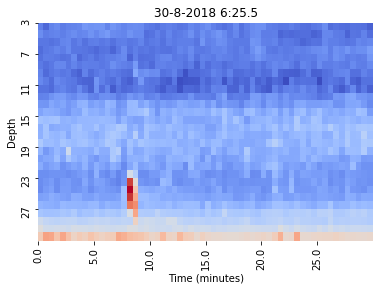

In [210]:
wp.make_heatmap(predicted_wakes[0, 3, :-1,:], predicted_wakes[0, 3,-1,:])

In [221]:
days = []
for uw in unknown_wakes_day:
    days.append(wp.stamp_to_date(uw)[1])

In [222]:
d_count = dict(Counter(days)) # Day: false negatives

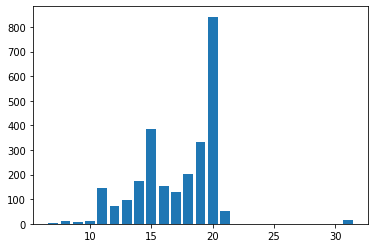

In [224]:
plt.bar(d_count.keys(), d_count.values())
plt.show()

In [225]:
days = []
for uw in unknown_wakes_day_night:
    days.append(wp.stamp_to_date(uw)[1])
d_count = dict(Counter(days)) # Day: false negatives

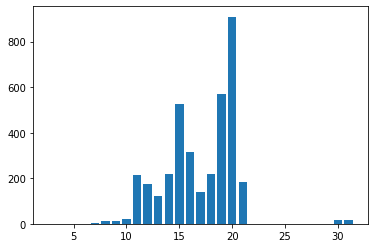

In [226]:
plt.bar(d_count.keys(), d_count.values())
plt.show()

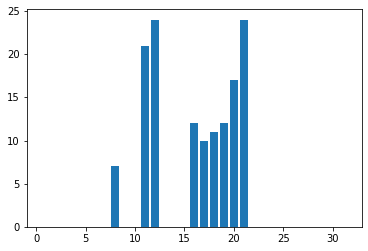

In [233]:
plt.bar(noise_distribution.keys(), noise_distribution.values())
plt.show()

Periods of noise according to the data description:
-	2018-09-08 07:00 – 2018-09-09 14:00
-	2018-09-11 07:00 - 2018-09-13 00:00  
-	2018-09-16 12:00 - 2018-09-17 10:00  
-	2018-09-18 08:00 - 2018-09-18 19:00  
-	2018-09-19 12:00 - 2018-09-20 17:00
-	2018-09-21 00:00 - 2018-09-23 10:00 


In [231]:
noise_distribution = { # Day: hours with noise according to data description
    8: 7,
    11: 21,
    12: 24,
    16: 12,
    17: 10,
    18: 11,
    19: 12,
    20: 17,
    21: 24,
    22: 0 #Cutoff
}

In [232]:
for i in [1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 14, 15, 23, 24, 25, 26, 27, 28, 29, 30, 31]:
    noise_distribution[i] = 0